In [ ]:
# @title #**EJECUTAR ESTA CELDA PRIMERO**
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers, backend, callbacks
import tensorflow.keras.utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# **CARGA DE LOS DATASETS**
Para cargar los datasets primeramente le damos la ruta a la carpeta de Drive donde montamos ambos datasets.

In [ ]:
drive.mount('/content/drive')
acceso_directo ="/Inteligencia Artificial"#@param {type:"string"}
base_path='drive/MyDrive'+acceso_directo+'/IA'
base_path_letters = base_path+'/Todas/'
hotel_train = base_path+'/dataset/Entrenamiento/'
img1 = cv2.imread(base_path_letters+'A/A37.jpg',cv2.IMREAD_GRAYSCALE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Verificación del contenido en las rutas
# Listar todas las carpetas y archivos en la ruta base
# Ruta base de las carpetas de imágenes
labels = os.listdir(base_path_letters)
print(labels)

labels_hot_t = os.listdir(hotel_train)
print(labels_hot_t)

['B', 'K', 'I', 'C', 'E', 'A', 'D', 'L', 'H', 'F', 'T', 'P', 'Q', 'U', 'R', 'N', 'W', 'V', 'O', 'M', 'X', 'Y']
['CINCO', 'BIENVENIDO', 'CAMA', 'AGOSTO', 'COMO_ESTA', 'BIEN', 'ABRIL', 'CUATRO', 'CON_MUCHO_GUSTO', 'ADULTO', 'DOMINGO', 'HABITACION', 'GRACIAS', 'DOS', 'HOTEL', 'DICIEMBRE', 'JUEVES', 'HOLA', 'FEBRERO', 'ENERO', 'LUNES', 'JUNIO', 'MAL', 'MAYO', 'NINO', 'MIERCOLES', 'JULIO', 'NO', 'MARZO', 'MARTES', 'POR_FAVOR', 'UNO', 'OCTUBRE', 'SEPTIEMBRE', 'SABADO', 'NOVIEMBRE', 'TRES', 'SI', 'VIERNES']


# **DEFINICIÓN DE LAS FUNCIONES**
### NOTA: ESCOJA SOLO UNA FUNCIÓN DE PREPROCESAMIENTO
- Función 1 (Utilizando OTSU)
  - Se aplica umbralización utilizando el método de OTSU para separar los píxeles en blanco y negro.
- Función 2 (Utilizando CLAHE)
  - Se aplica ecualización del histograma para mejorar el contraste de la imagen. Esto ayuda a distribuir mejor los niveles de intensidad en la imagen.
  - Luego se utiliza un objeto CLAHE con un límite de recorte  de 2.0 y un tamaño de cuadrícula de 8x8.
  - Y se aplica CLAHE a la imagen ecualizada para mejorar el contraste local.
- Función 3 (Utilizando CANNY)
  - Se aplica un filtro Gaussiano para suavizar la imagen y reducir el ruido. Los parámetros (5, 5) indican el tamaño del kernel Gaussiano y 0 especifica la desviación estándar en ambas direcciones x e y.
  - Luego se utiliza algoritmo de detección de bordes Canny a la imagen suavizada para obtener los bordes. Esto se hace con cv2.Canny(smoothed, 30, 85). Los parámetros 30 y 85 son los umbrales mínimo y máximo respectivamente, utilizados en el algoritmo Canny para determinar la intensidad de los bordes.
  
  -

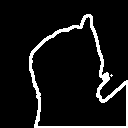

In [ ]:
# @title Función 1
def preprocess_and_extract_features(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar la imagen a un tamaño fijo
    image = cv2.resize(image, (128, 128))

    # Aplicar umbralización
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar contornos en una imagen en blanco
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

    # Extraer características HOG
    features, _ = hog(contour_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features, image

image =cv2.resize(img1, (128, 128))
_, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = np.zeros_like(image)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
cv2_imshow(contour_image)

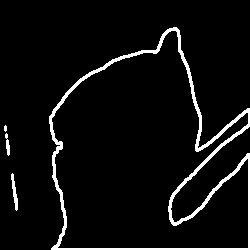

In [ ]:
# @title Función 2
def preprocess_and_extract_features(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Redimensionar la imagen a un tamaño fijo
    image = cv2.resize(image, (128, 128))

    # Aplicar ecualización del histograma
    img = cv2.equalizeHist(image)

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Aplicar filtro Gaussian
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Aplicar umbralización
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar contornos en una imagen en blanco
    contour_image = np.zeros_like(img)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

    # Extraer características HOG
    features, _ = hog(contour_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features, image

image = cv2.resize(img1, (128, 128))
image = cv2.equalizeHist(img1)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image = clahe.apply(image)
image = cv2.GaussianBlur(image, (5, 5), 0)
_, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = np.zeros_like(image)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
cv2_imshow(contour_image)

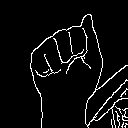

In [ ]:
# @title Función 3
def preprocess_and_extract_features(image_path):
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Redimensionar la imagen a un tamaño fijo
    image = cv2.resize(image, (128, 128))

    # Aplicar filtrado gaussiano para suavizar la imagen
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)

    # Aplicar detección de bordes con el algoritmo de Canny
    edges = cv2.Canny(smoothed, 30, 85)

    # Extraer características HOG
    features, _ = hog(edges, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features, image

image = cv2.resize(img1, (128, 128))
smoothed = cv2.GaussianBlur(image, (5, 5), 0)
edges = cv2.Canny(smoothed, 30, 85)
cv2_imshow(edges)

In [ ]:
# @title Función de carga de imágenes
# Función para cargar imágenes y etiquetas
def load_images_and_labels(base_path):
    X = []
    y = []
    original_images = []
    labels = os.listdir(base_path)  # Lista de carpetas (una por cada letra)
    for label in labels:
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                if os.path.isfile(image_path):
                    features, original_image = preprocess_and_extract_features(image_path)
                    X.append(features)
                    y.append(label)
                    original_images.append(original_image)
    return np.array(X), np.array(y), np.array(original_images)

In [ ]:
# @title Función para el plot de los resultados
# Función para visualizar las predicciones
def plot_predictions(images, true_labels, predicted_labels, predicted_probs, class_names, num_images=90, grid_shape=(15, 6)):
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    for i in range(num_images):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(images[i], cmap='gray')
        true_label_name = class_names[true_labels[i]]
        predicted_label_name = class_names[predicted_labels[i]]
        predicted_prob = np.max(predicted_probs[i])
        color = 'blue' if true_labels[i] == predicted_labels[i] else 'red'
        title = f"True: {true_label_name}\nPred: {predicted_label_name}\nAcc: {predicted_prob:.2f}"
        ax.set_title(title, color=color)
        ax.axis('off')

    # Remove empty subplots if num_images < rows * cols
    for i in range(num_images, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# **ENTRENAMIENTO**

In [ ]:
# @title Carga de imagenes dataset de letras
# Cargar las imágenes y etiquetas
X, y, original_images = load_images_and_labels(base_path_letters)

# Convertir las etiquetas a un formato numérico
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# @title Train-test Letras (80% train 20% test)
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test, original_images_train, original_images_test = train_test_split(X, y_encoded, original_images, test_size=0.2, random_state=42)

In [ ]:
# @title Carga de imagenes dataset hotelero
# Cargar las imágenes y etiquetas
X_hot, y_hot, original_images_hot = load_images_and_labels(hotel_train)

# Convertir las etiquetas a un formato numérico
label_encoder = LabelEncoder()
y_encoded_hot = label_encoder.fit_transform(y_hot)

In [ ]:
# @title Train-test Hotel (80% train 20% test)
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_hot, X_test_hot, y_train_hot, y_test_hot, original_images_hot_train, original_images_hot_test = train_test_split(X_hot, y_encoded_hot, original_images_hot, test_size=0.2, random_state=42)

## **Selección del modelo y predicciones**

### **Modelo Machine Learning**

In [ ]:
# @title Super Vector Machine **Letras**
# Entrenar un modelo SVM
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

# Realizar predicciones
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9402573529411765


In [ ]:
# @title Random Forest **Letras**
# Entrenar un Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de prueba
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9319852941176471


In [ ]:
# @title Super Vector Machine **Sector Hotelero**
# Entrenar un modelo SVM
clf_hot = svm.SVC(probability=True)
clf_hot.fit(X_train_hot, y_train_hot)

# Realizar predicciones
y_pred_hot = clf_hot.predict(X_test_hot)
y_pred_prob_hot = clf_hot.predict_proba(X_test_hot)
accuracy = accuracy_score(y_test_hot, y_pred_hot)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9982053582873991


In [ ]:
# @title Resultados Algoritmo #1 (OTSU-SVM Letras)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_test, y_test, y_pred, y_pred_prob, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #2 (CLAHE-SVM Letras)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_test, y_test, y_pred, y_pred_prob, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #3 (Canny-SVM Letras)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_test, y_test, y_pred, y_pred_prob, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #4 (OTSU-SVM Sector Hotelero)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_hot_test, y_test_hot, y_pred_hot, y_pred_prob_hot, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #5 (CLAHE-SVM Sector Hotelero)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_hot_test, y_test_hot, y_pred_hot, y_pred_prob_hot, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #6 (Canny-SVM Sector Hotelero)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_hot_test, y_test_hot, y_pred_hot, y_pred_prob_hot, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Resultados Algoritmo #7 (Canny-RandomForest Letras)
# Mostrar las predicciones
print(f"Accuracy: {accuracy}")
class_names = label_encoder.classes_
plot_predictions(original_images_test, y_test, y_pred, y_pred_prob, class_names)

Output hidden; open in https://colab.research.google.com to view.

### **Modelo Deep Learning**

In [ ]:
# Convertir las etiquetas a un formato numérico
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convertir las etiquetas a one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Verificar el número de clases
num_classes = len(label_encoder.classes_)
print("Número de clases:", num_classes)

# Verificar las formas
print("Forma de X:", X.shape)
print("Forma de y_encoded:", y_encoded.shape)
print("Forma de y_one_hot:", y_one_hot.shape)

# Reformatear los datos de entrada para que tengan la forma esperada por el modelo (40, 40, 1)
X = np.reshape(original_images, (-1, 40, 40, 1))

# Normalizar los datos de entrada si es necesario
X = X.astype('float32') / 255

# Verificar la forma de X después del reshape
print("Forma de X después del reshape:", X.shape)

Número de clases: 22
Forma de X: (5439, 36)
Forma de y_encoded: (5439,)
Forma de y_one_hot: (5439, 22)
Forma de X después del reshape: (5439, 40, 40, 1)


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [ ]:
# Convertir las etiquetas a un formato numérico
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convertir las etiquetas a one-hot encoding
y_one_hot = to_categorical(y_encoded)

In [ ]:
modelo = Sequential()
modelo.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 1)))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modelo.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
modelo.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Flatten())
modelo.add(Dense(70, activation='relu'))
modelo.add(Dense(50, activation='relu'))
modelo.add(Dense(30, activation='relu'))
modelo.add(Dense(22, activation='softmax'))
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7

In [ ]:
adam = optimizers.Adam(learning_rate=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
checkpointer = callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
M = modelo.fit(X, y_one_hot, batch_size=100, epochs=10, validation_data=(X_test,y_test), callbacks=[checkpointer], verbose=True)

Epoch 1/10
55/55 [==============================] - 8s 27ms/step - loss: 3.0904 - accuracy: 0.0443 - val_loss: 3.0887 - val_accuracy: 0.0450
Epoch 2/10
19/55 [=========>....................] - ETA: 0s - loss: 3.0880 - accuracy: 0.0511

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 8ms/step - loss: 3.0867 - accuracy: 0.0495 - val_loss: 3.0566 - val_accuracy: 0.0653
Epoch 3/10
55/55 [==============================] - 0s 8ms/step - loss: 2.8132 - accuracy: 0.1316 - val_loss: 2.3468 - val_accuracy: 0.2638
Epoch 4/10
55/55 [==============================] - 0s 9ms/step - loss: 2.0100 - accuracy: 0.3504 - val_loss: 1.6355 - val_accuracy: 0.4605
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 1.4546 - accuracy: 0.5135 - val_loss: 1.1406 - val_accuracy: 0.6369
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 1.0718 - accuracy: 0.6457 - val_loss: 0.8826 - val_accuracy: 0.7013
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.8911 - accuracy: 0.7049 - val_loss: 0.7787 - val_accuracy: 0.7362
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.7088 - accuracy: 0.7674 - val_loss: 0.6303 - val_accuracy: 0.7849
Epoch 9/10
55/55 [=========